In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.linalg import cholesky, solve_triangular

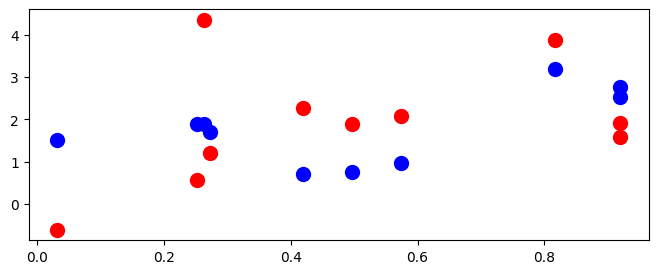

In [2]:
N = 10
train_X = np.sort(np.random.rand(N), axis=0) # training data locations!

sigma_1 = 0.1 # noise!
train_y1 = np.sin(10*train_X) + np.exp(train_X) + \
                sigma_1 * np.random.randn(10) # observations!

sigma_2 = 1.5
train_y2 = np.sin(10*train_X) + np.exp(train_X) + \
                sigma_2 * np.random.randn(10) 

fig = plt.figure(figsize=(8,3))
plt.plot(train_X, train_y1, 'bo', ms=10)
plt.plot(train_X, train_y2, 'ro', ms=10)
plt.show()

Let us define a new kernel

In [3]:
def squared_exp(xa, xb, amp, ll):
    Xa, Xb = get_tiled(xa, xb)
    return amp**2 * np.exp(-0.5 * 1./ll**2 * (Xa - Xb)**2 )

def get_tiled(xa, xb):
    m, n = len(xa), len(xb)
    xa, xb = xa.reshape(m,1) , xb.reshape(n,1)
    Xa = np.tile(xa, (1, n))
    Xb = np.tile(xb.T, (m, 1))
    return Xa, Xb

def get_posterior(amp, ll, x, x_data, y_data, noise_1, noise_2):
    u = y_data.shape[0]
    mu_y = np.mean(y_data)
    y = (y_data - mu_y).reshape(u,1)
    m = int(u/2)
    
    # Re-write Sigma now!
    # Sigma = noise * np.eye(u)
    Sigma = np.diag( np.hstack([np.ones((m))*noise_1**2, \
                                np.ones((m))*noise_2**2]) )

    Kxx = kernel(x_data, x_data, amp, ll)
    Kxpx = kernel(x, x_data, amp, ll)
    Kxpxp = kernel(x, x, amp, ll)
    
    # Inverse
    jitter = np.eye(u) * 1e-12
    L = cholesky(Kxx + Sigma + jitter)
    S1 = solve_triangular(L.T, y, lower=True)
    S2 = solve_triangular(L.T, Kxpx.T, lower=True).T
    
    mu = S2 @ S1  + mu_y
    cov = Kxpxp - S2 @ S2.T
    return mu, cov

In [4]:
def kernel(xa, xb, amp, ll):
    rho = 0.8
    C = np.array([[1.0, rho], 
                  [rho, 1.0]])
    K = squared_exp(xa, xb, amp, ll)
    return np.kron(C, K)

In [5]:
# Hyperparameters & noise!
amp = 1.0
ll = 0.2
noise_1 = sigma_1**2
noise_2 = sigma_2**2

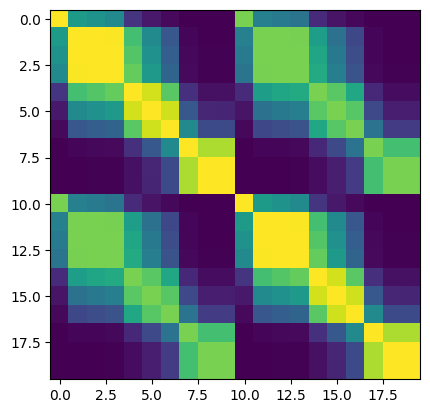

In [6]:
K_ = kernel(train_X, train_X, amp, ll)
plt.imshow(K_)

In [7]:
# Lets plot the posteriors!
train_y = np.hstack([train_y1, train_y2])

In [8]:
M = 150
test_X = np.linspace(0, 1, M)
mu, cov = get_posterior(amp, ll, test_X, \
                        train_X, train_y, noise_1, noise_2)

In [9]:
# Task 1
mu_1 = mu[0:M].flatten()
std_1 = np.sqrt(np.diag(cov))[0:M].flatten()

# Task 2
mu_2 = mu[M:].flatten()
std_2 = np.sqrt(np.diag(cov))[M:].flatten()

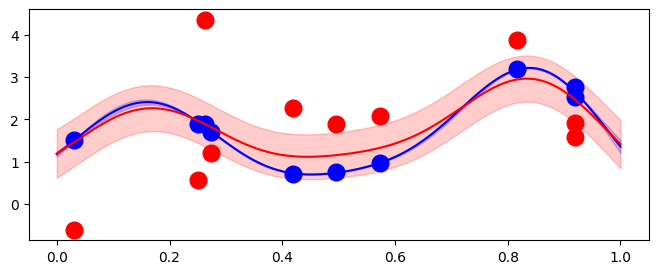

In [10]:
fig = plt.figure(figsize=(8,3))
plt.plot(train_X, train_y1, 'bo', ms=12)
plt.plot(train_X, train_y2, 'ro', ms=12)

# Task 1
plt.plot(test_X, mu_1, 'b-')
plt.fill_between(test_X, mu_1 + std_1, mu_1 - std_1, \
                 color='blue', alpha=0.2)

# Task 2
plt.plot(test_X, mu_2, 'r-')
plt.fill_between(test_X, mu_2 + std_2, mu_2 - std_2, \
                 color='red', alpha=0.2)


plt.show()